#Genetic Algorithm Implementation

##Genetic Algorithm Implementation with Binary Encoding for 1D function optimization


###Key Components:
- Binary encoding/decoding
- Single-point crossover
- Binary tournament selection
- Uniform mutation
- Elitist population replacement

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)

Core Genetic Algorithm Functions

In [ ]:
#Binary encoding/decoding
def logical2real(logical_vector, a, b):
    """
    Convert a binary chromosome to a real value within [a,b] using binary encoding.

    Parameters:
    - logical_vector: Binary array (chromosome)
    - a: Lower bound of search space
    - b: Upper bound of search space

    Returns:
    - Real value in (a,b) corresponding to the binary encoding
    """
    len_chromosome = len(logical_vector)
    active_bits = np.where(logical_vector)[0]  # Get indices of True/1 values

    # Convert binary to unsigned integer
    uint_value = np.sum(2**(len_chromosome - 1 - active_bits))

    # Normalize to [0,1) range
    normalized_value = uint_value / (2**len_chromosome)

    # Map to (a,b) interval with center adjustment
    real_value = (a + normalized_value * (b - a) +
                 0.5 * (b - a) / (2**len_chromosome))

    return real_value

In [ ]:
#Population initialization
def BE_initpop(ngenes, popsize=1):
    """
    Initialize random binary population.

    Parameters:
    - ngenes: Chromosome length
    - popsize: Population size

    Returns:
    - Random binary population matrix
    """
    return np.random.rand(popsize, ngenes) > 0.5

In [ ]:
#Fitness evaluation
def BE_evaluatefitness(f, P, a, b):
    """
    Evaluate fitness for each individual in population P.

    Parameters:
    - f: Objective function to minimize
    - P: Population matrix (each row is a binary chromosome)
    - a: Lower bound
    - b: Upper bound

    Returns:
    - Array of fitness values
    """
    fitness = np.zeros(P.shape[0])
    for i in range(P.shape[0]):
        # Convert binary to real value and evaluate
        fitness[i] = f(logical2real(P[i,:], a, b))
    return fitness

In [ ]:
#Selection operators
def binarytournament(P, fit_P, popsize):
    """
    Binary tournament selection for parent selection.

    Parameters:
    - P: Population matrix
    - fit_P: Fitness values
    - popsize: Size of mating pool to create

    Returns:
    - MP: Mating pool population
    """
    MP = np.zeros((popsize, P.shape[1]), dtype=bool)
    population_size = P.shape[0]

    for i in range(popsize):
        # Randomly select two individuals
        competitors = np.random.choice(population_size, 2, replace=False)

        # Select the one with better fitness (minimization)
        if fit_P[competitors[0]] < fit_P[competitors[1]]:
            MP[i,:] = P[competitors[0],:]
        else:
            MP[i,:] = P[competitors[1],:]

    return MP

In [ ]:
#Crossover operators
def BE_XOVER_singlepoint(parent1, parent2):
    """
    Single-point crossover between two parent chromosomes.

    Parameters:
    - parent1: First parent chromosome (binary array)
    - parent2: Second parent chromosome (binary array)

    Returns:
    - offsprings: Two offspring chromosomes (2D array)
    - splitpoint: Crossover point (for debugging)
    """
    chromosome_length = len(parent1)

    # Random crossover point (avoiding ends)
    splitpoint = np.random.randint(1, chromosome_length - 1)

    # Create offspring
    offspring1 = np.concatenate((parent1[:splitpoint],
                                parent2[splitpoint:]))
    offspring2 = np.concatenate((parent2[:splitpoint],
                                parent1[splitpoint:]))

    return np.vstack((offspring1, offspring2)), splitpoint

In [ ]:
#Mutation operator
def BE_MUT_unifall(chromosome, pmut):
    """
    Uniform mutation applied to all genes in a chromosome.

    Parameters:
    - chromosome: Binary chromosome to mutate
    - pmut: Probability of mutation for each gene

    Returns:
    - Mutated chromosome
    """
    # Create mutation mask
    mutation_mask = np.random.rand(len(chromosome)) < pmut

    # Flip bits where mutation occurs
    mutated = np.logical_xor(chromosome, mutation_mask)

    return mutated

Main Genetic Algorithm

In [ ]:
def GA_BE_1D(f, a, b, generations, chrsize, popsize, pmutallgenes,
             displayAndPlot=False):
    """
    Canonical Genetic Algorithm with Binary Encoding for 1D function minimization.

    Parameters:
    - f: Objective function to minimize
    - a: Lower bound of search space
    - b: Upper bound of search space
    - generations: Number of generations
    - chrsize: Chromosome length (bits)
    - popsize: Population size (must be even)
    - pmutallgenes: Mutation probability per gene
    - displayAndPlot: Whether to show convergence plot

    Returns:
    - x_opt: Best solution found
    - f_opt: Best fitness found
    - best_fit: Array of best fitness per generation
    """
    if popsize % 2 == 1:
        raise ValueError("Population size must be even.")

    # Initialize population
    P = BE_initpop(chrsize, popsize)

    # Evaluate initial fitness
    fit_P = BE_evaluatefitness(f, P, a, b)

    # Track best fitness per generation
    best_fit = np.zeros(generations)
    best_fit[0] = np.min(fit_P)

    # Evolution loop
    for t in range(1, generations):
        # 1. Selection - Create mating pool
        MP = binarytournament(P, fit_P, popsize)

        # 2. Shuffle mating pool to randomize pairs
        MP = MP[np.random.permutation(popsize), :]

        # 3. Crossover - Create offspring population Q
        Q = np.zeros((popsize, chrsize), dtype=bool)
        for i in range(0, popsize, 2):
            offsprings, _ = BE_XOVER_singlepoint(MP[i,:], MP[i+1,:])
            Q[i:i+2,:] = offsprings

        # 4. Mutation
        for i in range(popsize):
            Q[i,:] = BE_MUT_unifall(Q[i,:], pmutallgenes)

        # 5. Evaluate offspring fitness
        fit_Q = BE_evaluatefitness(f, Q, a, b)

        # 6. Combine parent and offspring populations
        R = np.vstack((P, Q))
        fit_R = np.concatenate((fit_P, fit_Q))

        # 7. Elitist selection - keep best individuals
        sorted_indices = np.argsort(fit_R)
        new_P = R[sorted_indices[:popsize], :]
        fit_new_P = fit_R[sorted_indices[:popsize]]

        # 8. Update population
        P = new_P
        fit_P = fit_new_P

        # 9. Track best fitness
        best_fit[t] = np.min(fit_P)

    # Find best solution
    best_idx = np.argmin(fit_P)
    f_opt = fit_P[best_idx]
    x_opt = logical2real(P[best_idx,:], a, b)

    # Visualization
    if displayAndPlot:
        plt.figure(figsize=(12, 5))

        # Full convergence plot
        plt.subplot(1, 2, 1)
        plt.plot(range(generations), best_fit, '-b')
        plt.xlim([0, generations-1])
        plt.title('Best Fitness per Generation')
        plt.xlabel('Generation')
        plt.ylabel('Fitness')

        # Early generations zoom
        plt.subplot(1, 2, 2)
        early_gen = min(30, generations)
        plt.plot(range(early_gen), best_fit[:early_gen], '-b')
        plt.xlim([0, early_gen-1])
        plt.title(f'First {early_gen} Generations')
        plt.xlabel('Generation')
        plt.ylabel('Fitness')

        plt.tight_layout()
        plt.show()

    return x_opt, f_opt, best_fit

Simulated Binary Crossover (Simplified)

In [ ]:
def GA_RE_crossover_sbx_simplified(p1, p2, lb, ub, eta, u=None):
    """
    Simplified Simulated Binary Crossover (SBX) for real-valued encoding.

    Parameters:
    - p1, p2: Parent chromosomes
    - lb, ub: Lower/upper bounds for each gene
    - eta: Distribution index (controls spread)
    - u: Optional random number for reproducibility

    Returns:
    - o1, o2: Offspring chromosomes
    """
    p1 = np.asarray(p1).flatten()
    p2 = np.asarray(p2).flatten()
    lb = np.asarray(lb).flatten()
    ub = np.asarray(ub).flatten()

    if u is None:
        u = np.random.rand()

    # Calculate spread factor
    if u <= 0.5:
        betaq = (2*u)**(1.0/(eta + 1))
    else:
        betaq = (1/(2*(1-u)))**(1.0/(eta + 1))

    # Create offspring
    o1 = 0.5*((1+betaq)*p1 + (1-betaq)*p2)
    o2 = 0.5*((1-betaq)*p1 + (1+betaq)*p2)

    # Apply bounds
    o1 = np.clip(o1, lb, ub)
    o2 = np.clip(o2, lb, ub)

    # Handle identical genes
    epsilon = 1e-14
    identical = np.abs(p1 - p2) < epsilon
    o1[identical] = p1[identical]
    o2[identical] = p1[identical]

    return o1, o2


Simulated Binary Crossover (Advanced)

In [ ]:
def GA_RE_crossover_sbx_advanced(p1, p2, lb, ub, eta, u=None):
    """
    Advanced Simulated Binary Crossover (SBX) for real-valued encoding.

    Parameters:
    - p1, p2: Parent chromosomes
    - lb, ub: Lower/upper bounds for each gene
    - eta: Distribution index (controls spread)
    - u: Optional random numbers for reproducibility

    Returns:
    - o1, o2: Offspring chromosomes
    """
    p1 = np.asarray(p1).flatten()
    p2 = np.asarray(p2).flatten()
    lb = np.asarray(lb).flatten()
    ub = np.asarray(ub).flatten()

    if u is None:
        u = np.random.rand(len(p1))
    else:
        u = np.asarray(u).flatten()

    # Initialize offspring
    o1 = p1.copy()
    o2 = p2.copy()
    epsilon = 1e-14

    for i in range(len(p1)):
        if abs(p1[i] - p2[i]) > epsilon:
            # Order parents
            x_min, x_max = sorted([p1[i], p2[i]])

            # Calculate beta for lower bound
            beta_low = 1.0 + (2.0 * (x_min - lb[i]) / (x_max - x_min))
            alpha_low = 2.0 - beta_low**(-(eta + 1))

            if u[i] <= 1.0 / alpha_low:
                betaq_low = (u[i] * alpha_low)**(1.0 / (eta + 1))
            else:
                betaq_low = (1.0 / (2.0 - u[i] * alpha_low))**(1.0 / (eta + 1))

            c1 = 0.5 * ((x_min + x_max) - betaq_low * (x_max - x_min))

            # Calculate beta for upper bound
            beta_up = 1.0 + (2.0 * (ub[i] - x_max) / (x_max - x_min))
            alpha_up = 2.0 - beta_up**(-(eta + 1))

            if u[i] <= 1.0 / alpha_up:
                betaq_up = (u[i] * alpha_up)**(1.0 / (eta + 1))
            else:
                betaq_up = (1.0 / (2.0 - u[i] * alpha_up))**(1.0 / (eta + 1))

            c2 = 0.5 * ((x_min + x_max) + betaq_up * (x_max - x_min))

            # Ensure bounds and assign
            c1 = np.clip(c1, lb[i], ub[i])
            c2 = np.clip(c2, lb[i], ub[i])

            if np.random.rand() <= 0.5:
                o1[i], o2[i] = c2, c1
            else:
                o1[i], o2[i] = c1, c2

    return o1, o2


Example

Example 1: Rastrigin Function


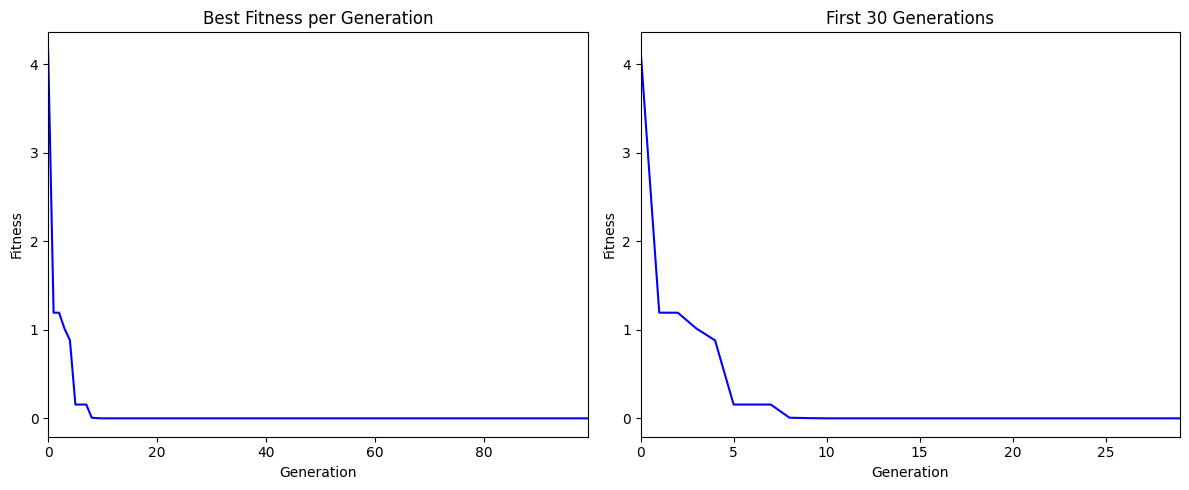

Optimal solution: x = 0.001221, f(x) = 0.000296
Known optimum: x = 0.0, f(x) = 0.0

Example 2: SBX Crossover Test
Parents:    [0.2 0.5 0.8] and [0.6 0.4 0.3]
Offspring:  [0.23131347 0.49217163 0.76085817] and [0.56868653 0.40782837 0.33914183]


In [ ]:
if __name__ == "__main__":
    # Example 1: Minimize Rastrigin function
    print("Example 1: Rastrigin Function")
    def rastrigin(x):
        return 10 + x**2 - 10*np.cos(2*np.pi*x)

    x_opt, f_opt, _ = GA_BE_1D(rastrigin, -5, 5,
                               generations=100,
                               chrsize=12,
                               popsize=20,
                               pmutallgenes=0.1,
                               displayAndPlot=True)

    print(f"Optimal solution: x = {x_opt:.6f}, f(x) = {f_opt:.6f}")
    print("Known optimum: x = 0.0, f(x) = 0.0")

    # Example 2: Test SBX crossover
    print("\nExample 2: SBX Crossover Test")
    p1 = np.array([0.2, 0.5, 0.8])
    p2 = np.array([0.6, 0.4, 0.3])
    lb = np.array([0.0, 0.0, 0.0])
    ub = np.array([1.0, 1.0, 1.0])

    o1, o2 = GA_RE_crossover_sbx_simplified(p1, p2, lb, ub, eta=2, u=0.3)
    print(f"Parents:    {p1} and {p2}")
    print(f"Offspring:  {o1} and {o2}")

## Advanced Visualization

This part provides a complete implementation of a Genetic Algorithm
with binary encoding, featuring multiple visualization sections to demonstrate:

1. Population dynamics over generations
2. Fitness landscape with solution progression
3. Operator effects (crossover/mutation)
4. Convergence analysis
5. Real-time animation of the optimization process

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import clear_output
import time

In [ ]:
# Enhanced Visualization Functions

def plot_fitness_landscape(f, a, b, resolution=1000):
    """
    Visualize the 1D fitness landscape of the objective function.

    Parameters:
    - f: Objective function
    - a, b: Domain bounds
    - resolution: Number of points to evaluate
    """
    x = np.linspace(a, b, resolution)
    y = f(x)

    plt.figure(figsize=(10, 6))
    plt.plot(x, y, 'b-', linewidth=2, label='Fitness landscape')
    plt.title('Objective Function Fitness Landscape', fontsize=14)
    plt.xlabel('x', fontsize=12)
    plt.ylabel('f(x)', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()


In [ ]:
def plot_population_distribution(P, a, b, generation):
    """
    Visualize the population distribution across the search space.

    Parameters:
    - P: Population matrix
    - a, b: Search space bounds
    - generation: Current generation number
    """
    real_values = [logical2real(ind, a, b) for ind in P]

    plt.figure(figsize=(10, 4))
    plt.hist(real_values, bins=20, range=(a, b),
             color='skyblue', edgecolor='black')
    plt.title(f'Population Distribution (Generation {generation})', fontsize=14)
    plt.xlabel('Phenotype Value', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.xlim(a, b)
    plt.grid(True, alpha=0.3)
    plt.show()

In [ ]:
def animate_optimization_process(f, a, b, generations, chrsize, popsize, pmut):
    """
    Real-time animation showing the optimization process.

    Parameters:
    - f: Objective function
    - a, b: Search bounds
    - generations: Total generations
    - chrsize: Chromosome length
    - popsize: Population size
    - pmut: Mutation probability
    """
    # Initialize population
    P = BE_initpop(chrsize, popsize)
    fit_P = BE_evaluatefitness(f, P, a, b)

    # Prepare figure
    plt.figure(figsize=(12, 6))
    x_vals = np.linspace(a, b, 1000)
    y_vals = f(x_vals)

    for t in range(generations):
        # Evolutionary steps
        MP = binarytournament(P, fit_P, popsize)
        MP = MP[np.random.permutation(popsize), :]

        Q = np.zeros((popsize, chrsize), dtype=bool)
        for i in range(0, popsize, 2):
            offsprings, _ = BE_XOVER_singlepoint(MP[i,:], MP[i+1,:])
            Q[i:i+2,:] = offsprings

        for i in range(popsize):
            Q[i,:] = BE_MUT_unifall(Q[i,:], pmut)

        fit_Q = BE_evaluatefitness(f, Q, a, b)
        R = np.vstack((P, Q))
        fit_R = np.concatenate((fit_P, fit_Q))
        sorted_indices = np.argsort(fit_R)
        P = R[sorted_indices[:popsize], :]
        fit_P = fit_R[sorted_indices[:popsize]]

        # Convert population to real values
        real_pop = np.array([logical2real(ind, a, b) for ind in P])

        # Clear and update plot
        clear_output(wait=True)
        plt.clf()

        # Plot fitness landscape
        plt.subplot(1, 2, 1)
        plt.plot(x_vals, y_vals, 'b-', linewidth=2, label='Fitness')
        plt.scatter(real_pop, fit_P, c='red', s=50,
                   label=f'Gen {t} Population')
        best_idx = np.argmin(fit_P)
        plt.scatter(real_pop[best_idx], fit_P[best_idx],
                   c='gold', s=100, marker='*', label='Best Solution')
        plt.title(f'Generation {t+1}/{generations}', fontsize=12)
        plt.xlabel('x', fontsize=10)
        plt.ylabel('f(x)', fontsize=10)
        plt.legend()
        plt.grid(True, alpha=0.3)

        # Plot population histogram
        plt.subplot(1, 2, 2)
        plt.hist(real_pop, bins=20, range=(a, b),
                color='skyblue', edgecolor='black')
        plt.title('Population Distribution', fontsize=12)
        plt.xlabel('Phenotype Value', fontsize=10)
        plt.ylabel('Frequency', fontsize=10)
        plt.xlim(a, b)
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()
        time.sleep(0.1)  # Pause for visualization

In [ ]:
def plot_operator_effects(f, a, b, chrsize):
    """
    Visualize effects of genetic operators.

    Parameters:
    - f: Objective function
    - a, b: Search bounds
    - chrsize: Chromosome length
    """
    # Create initial parents
    parent1 = BE_initpop(chrsize, 1)[0]
    parent2 = BE_initpop(chrsize, 1)[0]

    # Apply crossover
    offsprings, _ = BE_XOVER_singlepoint(parent1, parent2)
    child1, child2 = offsprings[0], offsprings[1]

    # Apply mutation
    mutated1 = BE_MUT_unifall(parent1.copy(), 0.5)  # High mutation for demo
    mutated2 = BE_MUT_unifall(parent2.copy(), 0.5)

    # Convert to real values
    p1_val = logical2real(parent1, a, b)
    p2_val = logical2real(parent2, a, b)
    c1_val = logical2real(child1, a, b)
    c2_val = logical2real(child2, a, b)
    m1_val = logical2real(mutated1, a, b)
    m2_val = logical2real(mutated2, a, b)

    # Plot
    plt.figure(figsize=(14, 6))

    # Fitness landscape
    x = np.linspace(a, b, 1000)
    y = f(x)
    plt.plot(x, y, 'b-', alpha=0.3, label='Fitness landscape')

    # Parents and offspring
    plt.scatter([p1_val, p2_val], [f(p1_val), f(p2_val)],
               c='green', s=150, marker='o', label='Parents')
    plt.scatter([c1_val, c2_val], [f(c1_val), f(c2_val)],
               c='red', s=150, marker='^', label='Offspring (crossover)')
    plt.scatter([m1_val, m2_val], [f(m1_val), f(m2_val)],
               c='purple', s=150, marker='s', label='Mutated')

    # Arrows to show transformations
    plt.arrow(p1_val, f(p1_val), (c1_val-p1_val)/2, (f(c1_val)-f(p1_val))/2,
             head_width=0.1, head_length=0.1, fc='gray', ec='gray', linestyle='--')
    plt.arrow(p2_val, f(p2_val), (c2_val-p2_val)/2, (f(c2_val)-f(p2_val))/2,
             head_width=0.1, head_length=0.1, fc='gray', ec='gray', linestyle='--')
    plt.arrow(p1_val, f(p1_val), (m1_val-p1_val)/2, (f(m1_val)-f(p1_val))/2,
             head_width=0.1, head_length=0.1, fc='gray', ec='gray', linestyle=':')
    plt.arrow(p2_val, f(p2_val), (m2_val-p2_val)/2, (f(m2_val)-f(p2_val))/2,
             head_width=0.1, head_length=0.1, fc='gray', ec='gray', linestyle=':')

    plt.title('Genetic Operators Effect Visualization', fontsize=14)
    plt.xlabel('x', fontsize=12)
    plt.ylabel('f(x)', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

In [ ]:
def plot_convergence_analysis(f, a, b, param_ranges):
    """
    Analyze convergence for different parameter settings.

    Parameters:
    - f: Objective function
    - a, b: Search bounds
    - param_ranges: Dictionary of parameter ranges to test
    """
    plt.figure(figsize=(14, 8))

    # Test different population sizes
    if 'popsize' in param_ranges:
        for popsize in param_ranges['popsize']:
            _, _, best_fit = GA_BE_1D(f, a, b, generations=100,
                                     chrsize=12, popsize=popsize,
                                     pmutallgenes=0.1, displayAndPlot=False)
            plt.plot(best_fit, label=f'Pop size={popsize}')

    # Test different mutation rates
    if 'pmut' in param_ranges:
        for pmut in param_ranges['pmut']:
            _, _, best_fit = GA_BE_1D(f, a, b, generations=100,
                                     chrsize=12, popsize=20,
                                     pmutallgenes=pmut, displayAndPlot=False)
            plt.plot(best_fit, '--', label=f'Mut rate={pmut}')

    plt.title('Convergence Analysis for Different Parameters', fontsize=14)
    plt.xlabel('Generation', fontsize=12)
    plt.ylabel('Best Fitness', fontsize=12)
    plt.yscale('log')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

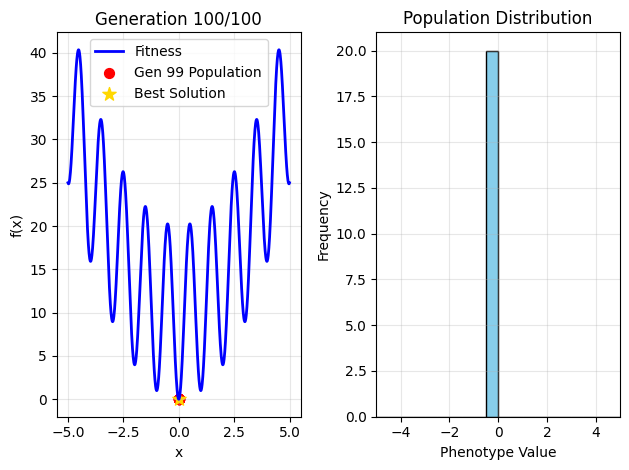


3. Genetic Operators Effect Visualization


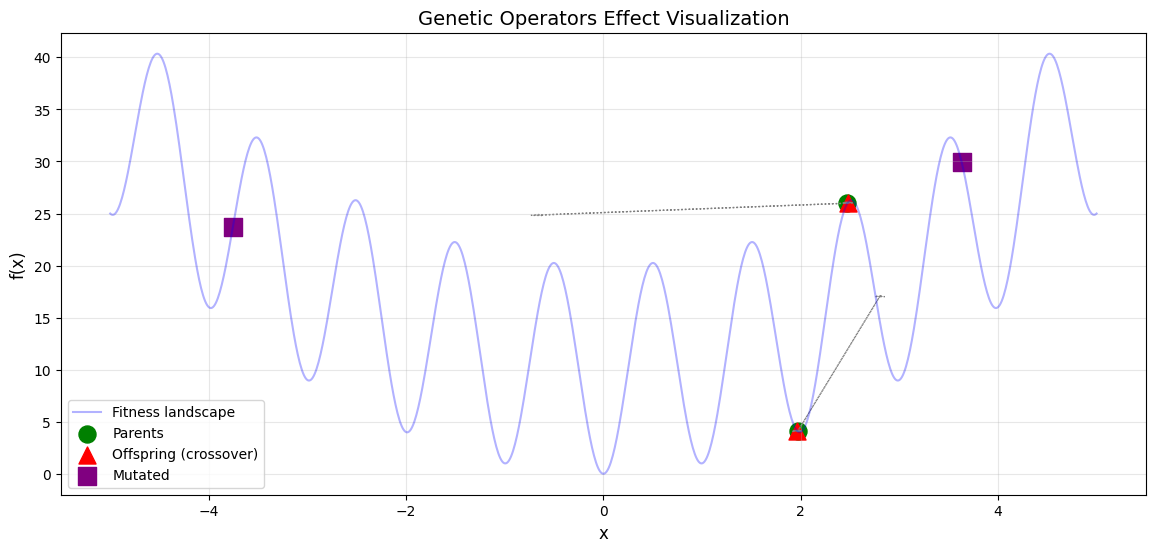


4. Parameter Sensitivity Analysis


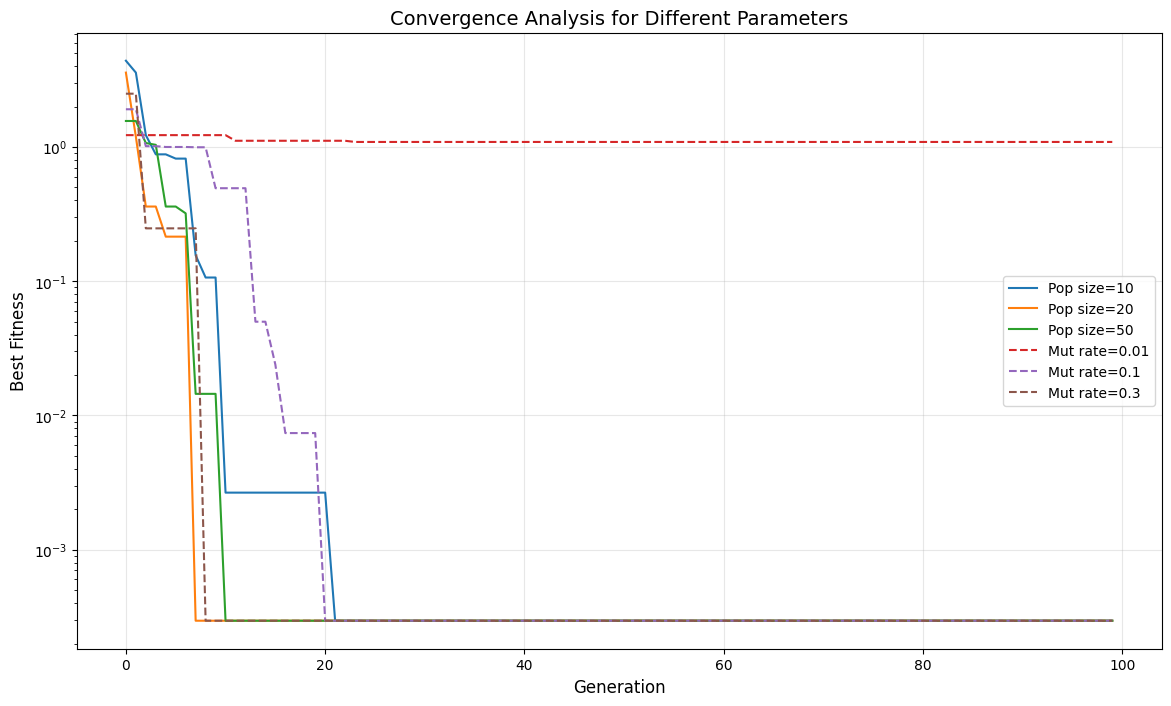


5. Complete Optimization Run


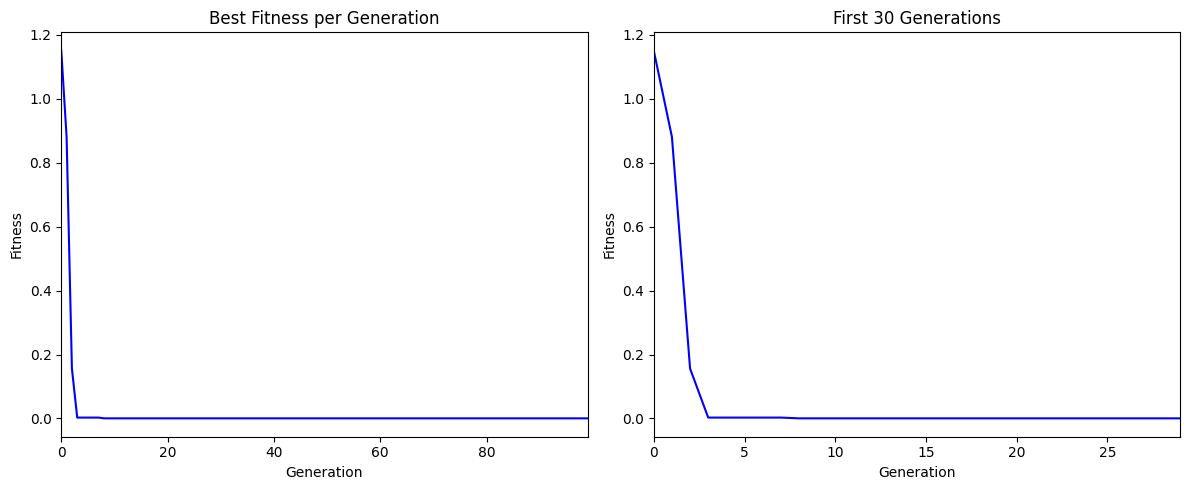


Optimal solution found: x = 0.001221, f(x) = 0.000296


In [ ]:
# Example Usage with Enhanced Visualization

if __name__ == "__main__":
    # Define test function (Rastrigin)
    def rastrigin(x):
        return 10 + x**2 - 10*np.cos(2*np.pi*x)

    # 1. Show fitness landscape
    print("1. Fitness Landscape Visualization")
    plot_fitness_landscape(rastrigin, -5, 5)

    # 2. Animate optimization process
    print("\n2. Optimization Process Animation")
    animate_optimization_process(rastrigin, -5, 5,
                               generations=100,
                               chrsize=12,
                               popsize=20,
                               pmut=0.1)

    # 3. Show operator effects
    print("\n3. Genetic Operators Effect Visualization")
    plot_operator_effects(rastrigin, -5, 5, chrsize=12)

    # 4. Parameter sensitivity analysis
    print("\n4. Parameter Sensitivity Analysis")
    param_ranges = {
        'popsize': [10, 20, 50],
        'pmut': [0.01, 0.1, 0.3]
    }
    plot_convergence_analysis(rastrigin, -5, 5, param_ranges)

    # 5. Full optimization with detailed plots
    print("\n5. Complete Optimization Run")
    x_opt, f_opt, best_fit = GA_BE_1D(rastrigin, -5, 5,
                                      generations=100,
                                      chrsize=12,
                                      popsize=20,
                                      pmutallgenes=0.1,
                                      displayAndPlot=True)

    print(f"\nOptimal solution found: x = {x_opt:.6f}, f(x) = {f_opt:.6f}")